### Импорт библиотек

In [1]:
import tarfile
import json 
from typing import List
from functools import partial
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import ADASYN

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score,  mean_squared_error, adjusted_rand_score
from sklearn.metrics import make_scorer

### Загрузка данных

In [2]:
#Распаковка архива
zipfile = 'hackathon_files_for_participants_ozon.tar.gz'
tar = tarfile.open(zipfile,"r:gz")
tar.extractall()
tar.close()

In [3]:
#Загрузка данных
df_train = pd.read_parquet('hackathon_files_for_participants_ozon/train_data.parquet', engine='pyarrow').reset_index(drop=True)
df_test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet', engine='pyarrow').reset_index(drop=True)
df_train_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/train_pairs.parquet', engine='pyarrow').reset_index(drop=True)
df_test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet', engine='pyarrow').reset_index(drop=True)

In [4]:
#Категории по уровням
df_train = df_train.join(pd.json_normalize(df_train.categories.apply(json.loads)))
df_test = df_test.join(pd.json_normalize(df_test.categories.apply(json.loads)))

In [5]:
df_train.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )
df_test.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )

In [6]:
df_train.shape

(457063, 12)

In [7]:
cat3_counts = df_train.cat3.value_counts().to_dict()
cat3_counts

{'Смартфоны, планшеты, мобильные телефоны': 59389,
 'Компьютер': 57572,
 'Чехол': 40775,
 'Расходник для печати': 38878,
 'Кабели и переходники': 26669,
 'Наушники и гарнитуры': 16944,
 'Смарт-часы': 14811,
 'Устройство ручного ввода': 14235,
 'Батарейки и аккумуляторы': 12548,
 'Зарядные устройства и док-станции': 12014,
 'Запчасти для ноутбуков': 11791,
 'Запчасти для смартфонов': 10716,
 'Жесткие диски, SSD и сетевые накопители': 10221,
 'Материнская плата': 9895,
 'Видеонаблюдение': 9791,
 'Защитные пленки и стекла': 9225,
 'Оптические приборы': 5874,
 'Карты памяти и флешки': 5741,
 'Телевизоры': 5504,
 'Игровая приставка': 5300,
 'Акустика и колонки': 5287,
 'Электронные модули': 5144,
 'Сетевое оборудование': 5026,
 'Видеокарты и графические ускорители': 4578,
 'Мониторы и запчасти': 4361,
 'Оперативная память': 3877,
 'Сетевые фильтры, разветвители и удлинители': 3658,
 'Принтеры и МФУ': 3643,
 'Аксессуары для фото и видеотехники': 2905,
 'Кронштейн': 2650,
 'Видеорегистратор':

In [8]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 470:
        cntr += cat3_counts[cat3]
        
cntr

4480

In [9]:
df_train['cat3_grouped'] = df_train.cat3.apply(lambda x: x if cat3_counts[x] > 470 else 'rest')

### Предобработка данных

In [10]:
merged = df_train_pairs.merge(df_train.add_suffix('1'), on = 'variantid1', how = 'left')
train = merged.merge(df_train.add_suffix('2'), on = 'variantid2', how = 'left')

In [11]:
merged = df_test_pairs.merge(df_test.add_suffix('1'), on = 'variantid1', how = 'left')
test = merged.merge(df_test.add_suffix('2'), on = 'variantid2', how = 'left')

In [12]:
#Косинусное расстояние (картинки)
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                    percentiles: List[int]):      
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = np.array(pairwise_distances(main_pic_embeddings_1, main_pic_embeddings_2, metric='cosine'))
    else:
        dist_m = np.array([[-1]])
        
    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()
   

    return pair_features




In [13]:
#Косинусное сходство (текст)
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt') # if necessary...
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))
vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words=['english','russian'])
def cosine_sim(text1, text2):
    try:
        tfidf = vectorizer.fit_transform([text1, text2])
        cos_sim = ((tfidf * tfidf.T).A)[0,1]
    except: 
        cos_sim = 0
    return cos_sim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tamar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#Заполним пропуски
train.characteristic_attributes_mapping1.fillna('{}', inplace=True)
train.characteristic_attributes_mapping2.fillna('{}', inplace=True)
test.characteristic_attributes_mapping1.fillna('{}', inplace=True)
test.characteristic_attributes_mapping2.fillna('{}', inplace=True)

In [15]:
#Оставим только совпадающие характеристики
def attr(attributes1, attributes2):
    dict1 = json.loads(attributes1)
    dict2 = json.loads(attributes2)
    common_keys = set(dict1.keys()) & set(dict2.keys())
    new_dict1 = {key: dict1[key] for key in common_keys}
    new_dict2 = {key: dict2[key] for key in common_keys}
    attributes1 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict1.items())
    attributes2 = ' '.join('{}: {}; '.format(key,', '.join(str(x) for x in val)) for key, val in new_dict2.items())
    return attributes1, attributes2

In [16]:
get_pic_features_func = partial(get_pic_features,percentiles=[0, 25, 50, 75])

In [17]:
train[['attributes1', 'attributes2']] = (
    train[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))
test[['attributes1', 'attributes2']] = (
    test[['characteristic_attributes_mapping1', 'characteristic_attributes_mapping2']].apply(
        lambda x: pd.Series(attr(*x)), axis=1))

In [18]:
train[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc', 'main_pic_dist_75_perc']] = (
    train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
train[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc', 'pic_dist_75_perc']] = (
    train[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [19]:
train['cosine_name_sim'] = (
    train[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
train['cosine_attr_sim'] = (
    train[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [20]:
test[['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc', 'main_pic_dist_75_perc']] = (
    test[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))
test[['pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc', 'pic_dist_75_perc']] = (
    test[['pic_embeddings_resnet_v11', 'pic_embeddings_resnet_v12']].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1))

In [21]:
test['cosine_name_sim'] = (
    test[['name1', 'name2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))
test['cosine_attr_sim'] = (
    test[['attributes1', 'attributes2']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [22]:
train['cosine_cat4_sim'] = (
    train[['cat41', 'cat42']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [23]:
test['cosine_cat4_sim'] = (
    test[['cat41', 'cat42']].apply(
        lambda x: pd.Series(cosine_sim(*x)), axis=1))

In [24]:
feats = ['main_pic_dist_0_perc', 'main_pic_dist_25_perc', 'main_pic_dist_50_perc', 'main_pic_dist_75_perc', 'pic_dist_0_perc', 'pic_dist_25_perc', 'pic_dist_50_perc', 'pic_dist_75_perc', 'cosine_name_sim', 'cosine_attr_sim', 'cosine_cat4_sim']

In [25]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped1"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [26]:
def all_metrics(y_true, y_pred, y_pred_proba, y_test, X_test):
    dict_metric = {}
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 1) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))
    
    pr_auc_macro_metr = pr_auc_macro(
            target_df=pd.DataFrame(y_test), 
            predictions_df=X_test,
            prec_level=0.75,
            cat_column='cat3_grouped1'
            )

    dict_metric['P'] = [P, 'ЕСТЬ совпадение товаров']
    dict_metric['N'] = [N, 'НЕТ совпадения товаров ']
    dict_metric['TP'] = [TP, 'Истинно совпавшие']
    dict_metric['TN'] = [TN, 'Истинно не-совпавшие']
    dict_metric['FP'] = [FP, 'Ложно совпавшие']
    dict_metric['FN'] = [FN, 'Ложно не-совпавшие']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred), 'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_true, y_pred), 'Точность определения']
    dict_metric['Recall'] = [recall_score(y_true, y_pred), 'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_proba), 'ROC-AUC']
    dict_metric['AUPRC'] = [average_precision_score(y_true, y_pred_proba), 'AUPRC']
    dict_metric['pr_auc_macro_metr'] = [pr_auc_macro_metr, 'pr_auc_macro_metr']

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)

In [27]:
X_train, X_test = train_test_split(train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=train[['target', 'cat3_grouped1']])

X_train, X_val = train_test_split(X_train[feats + ['target', 'variantid1', 'variantid2', 'cat3_grouped1']], 
    test_size=0.2, random_state=42, stratify=X_train[['target', 'cat3_grouped1']])

y_test = X_test[['target', 'variantid1', 'variantid2']]
X_test = X_test.drop(['target'], axis=1)

y_train = X_train['target']
y_val = X_val['target']

X_train = X_train.drop(['target'], axis=1)
X_val = X_val.drop(['target'], axis=1)




In [28]:
scoring = make_scorer(average_precision_score)

parameters ={'n_estimators': [200],
             'class_weight': [None, 'balanced'],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [3, 4, 5, 6, 7, 8],
             'min_samples_split': [0.005, 0.01, 0.05, 0.10],
             'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
             'criterion' :['gini', 'entropy']     ,
             'n_jobs': [-1]
           }

rfc = RandomizedSearchCV(RandomForestClassifier(), parameters, cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=random.seed()), scoring=scoring, n_jobs = -1)

rfc.fit(X_train[feats], y_train.values)

best_params_rfc = rfc.best_params_
best_estimator_rfc = rfc.best_estimator_

print('Лучшие параметры: ',rfc.best_params_)
print('average_precision_score: ',rfc.best_score_)

Лучшие параметры:  {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 0.005, 'min_samples_leaf': 0.01, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'class_weight': 'balanced'}
average_precision_score:  0.5647652229727007


In [29]:

model7 = AdaBoostClassifier(base_estimator=RandomForestClassifier(**best_params_rfc)
,algorithm='SAMME.R')

model7.fit(X_train[feats], y_train.values)

y_pred_proba = model7.predict_proba(X_test[feats])[:, 1]
y_pred = model7.predict(X_test[feats])
X_test['scores'] = model7.predict_proba(X_test[feats])[:, 1]
all_metrics(y_test.target, y_pred, y_pred_proba, y_test, X_test)

,Значение,Описание метрики
P,27003.000000,ЕСТЬ совпадение товаров
N,34305.000000,НЕТ совпадения товаров
TP,20415.000000,Истинно совпавшие
TN,24114.000000,Истинно не-совпавшие
FP,6588.000000,Ложно совпавшие
FN,10191.000000,Ложно не-совпавшие
Accuracy,0.726316,Доля верно определённых
Precision,0.667026,Точность определения
Recall,0.756027,Полнота определения
F1-score,0.708743,Среднее гармоническое Precision и Recall


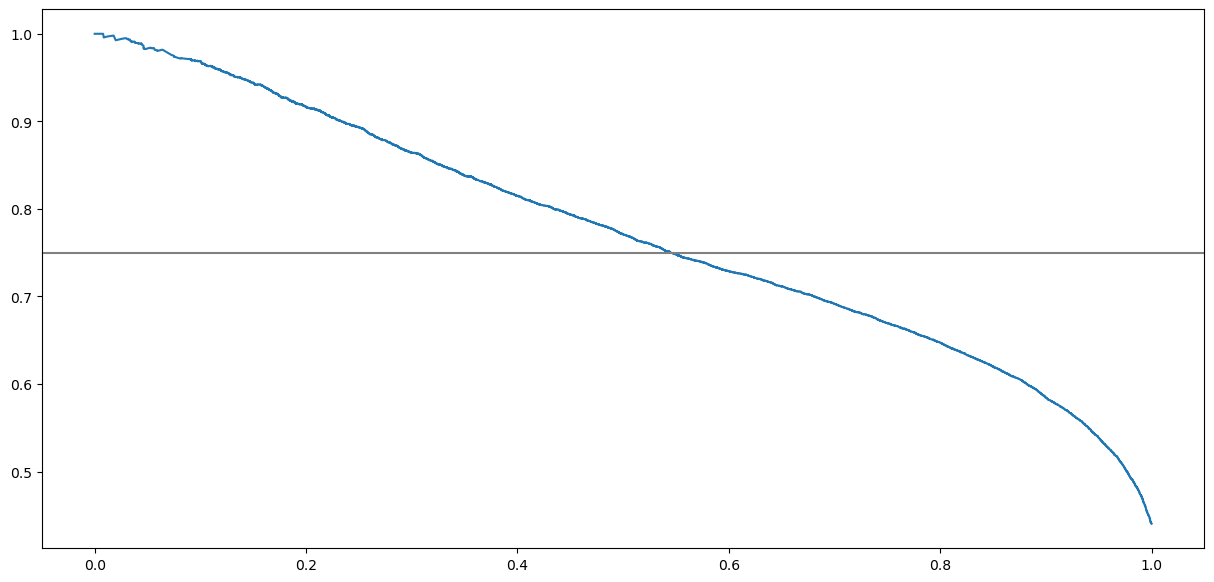

In [30]:
precision, recall, thrs = precision_recall_curve(y_test['target'], X_test['scores'])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [31]:
import pickle
# save
with open('model7.pkl','wb') as f:
    pickle.dump(model7,f)

In [32]:
# load
with open('model7.pkl', 'rb') as f:
    model7 = pickle.load(f)

### Submission

In [33]:
test.shape

(18084, 37)

In [34]:
test_cat3_counts = test.cat31.value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [35]:
test['cat3_grouped'] = test.cat31.apply(lambda x: x if test_cat3_counts[x] > 50 else 'rest')

In [36]:
submission = test.copy()

In [37]:
submission['target'] = model7.predict_proba(test[feats])[:, 1]

In [38]:
submission = submission[['variantid1', 'variantid2', 'cat3_grouped', 'target']]

In [39]:
submission.drop_duplicates().to_csv('submission_vc_m71.csv', index=False)